In [9]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import v2
from tqdm.auto import tqdm



## Utils

In [10]:
def show_image(img, num=4, rescale=None):
    img = img.cpu()
    if rescale:
      img += rescale[0]
      img /= rescale[1]
    img = torchvision.utils.make_grid(img, num)
    plt.imshow(img.permute(1, 2, 0).clip(0, 1))
    plt.show()

## Params

In [11]:
BATCH_SIZE = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
latent_dim = 200

## Get Data

In [12]:
size = 64
transforms = v2.Compose([torchvision.transforms.ToTensor(),
                         torchvision.transforms.Resize((size, size))])
dataset = torchvision.datasets.OxfordIIITPet('./', download=True, transform=transforms)
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True,
                                         num_workers=2)

torch.Size([64, 3, 64, 64])


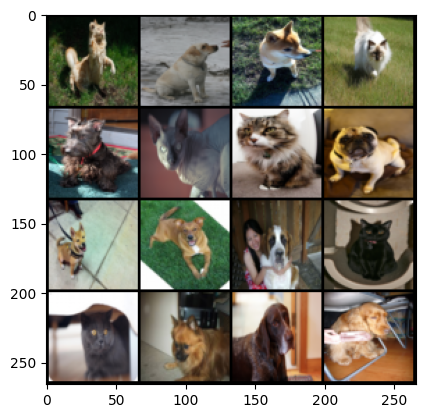

In [13]:
test_image = next(iter(dataloader))[0]
print(test_image.shape)
show_image(test_image[:16])

## Models

In [14]:
def conv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1, if_transpose=False, if_pool=False,
               device='cpu'):
    if if_transpose:
        block = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,
                                    device=device)]
    else:
        block = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,
                           device=device)]
    block.append(nn.InstanceNorm2d(out_channels, device=device))
    block.append(nn.GELU())
    if if_pool:
        block.append(nn.MaxPool2d(2))
    return nn.Sequential(*block)

class SimpleDiscriminator(nn.Module):
    def __init__(self, dims, kernel_sizes, strides, paddings, if_pools, device='cpu'):
        super(SimpleDiscriminator, self).__init__()
        self.input_norm = nn.InstanceNorm2d(3, device=device)
        self.device = device
        self.n_times = len(kernel_sizes)
        blocks = []
        for i in range(self.n_times-1):
            blocks.append(conv_block(dims[i],
                                     dims[i+1],
                                     kernel_size=kernel_sizes[i],
                                     stride=strides[i],
                                     padding=paddings[i],
                                     if_pool=if_pools[i]))
        self.block = nn.Sequential(*blocks)
        self.out_conv = nn.Conv2d(dims[-1], 1,
                                  kernel_size=kernel_sizes[-1],
                                  stride=strides[-1],
                                  padding=paddings[-1],
                                  device=device)
        self.flatten = nn.Flatten()
        #self.dense = nn.Linear() ## tu dodawać

    def forward(self, x):
        x = self.input_norm(x)
        x = self.block(x)
        x = self.out_conv(x)
        x = x.view(-1, 1)
        return x.to(self.device)

In [15]:
!git clone https://github.com/michal-boguslawski/Vision-models-pytorch
!mv Vision-models-pytorch vision_models_pytorch

Cloning into 'Vision-models-pytorch'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 22 (delta 6), reused 18 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (22/22), 5.25 KiB | 5.25 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [16]:
from vision_models_pytorch.vision_models import *


In [17]:
def conv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1, if_transpose=False, if_pool=False,
               device='cpu'):
    if if_transpose:
        block = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,
                                    device=device)]
    else:
        block = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,
                           device=device)]
    block.append(nn.InstanceNorm2d(out_channels, device=device))
    block.append(nn.GELU())
    if if_pool:
        block.append(nn.MaxPool2d(2))
    return nn.Sequential(*block)

class SimpleDiscriminator(nn.Module):
    def __init__(self, dims, kernel_sizes, strides, paddings, if_pools, device='cpu'):
        super(SimpleDiscriminator, self).__init__()
        self.input_norm = nn.InstanceNorm2d(3, device=device)
        self.device = device
        self.n_times = len(kernel_sizes)
        blocks = []
        for i in range(self.n_times-1):
            blocks.append(conv_block(dims[i],
                                     dims[i+1],
                                     kernel_size=kernel_sizes[i],
                                     stride=strides[i],
                                     padding=paddings[i],
                                     if_pool=if_pools[i],
                                     device=device))
        self.block = nn.Sequential(*blocks)
        self.out_conv = nn.Conv2d(dims[-1], 1,
                                  kernel_size=kernel_sizes[-1],
                                  stride=strides[-1],
                                  padding=paddings[-1],
                                  device=device)
        self.flatten = nn.Flatten()
        #self.dense = nn.Linear() ## tu dodawać

    def forward(self, x):
        x = self.input_norm(x)
        x = self.block(x)
        x = self.out_conv(x)
        x = x.view(-1, 1)
        return x.to(self.device)

## Initiate and test models

In [18]:
gen_dims = [latent_dim, 256, 128, 64, 32]
gen_kernel_sizes = [4, 4, 4, 8]
gen_strides = [2, 2, 2, 4]
gen_paddings = [0, 1, 1, 2]
generator = SimpleGenerator(latent_dim,
                            gen_dims,
                            gen_kernel_sizes,
                            gen_strides,
                            gen_paddings,
                            new_size=(size, size),
                            device=device)

disc_dims = [3, 64, 128, 256]
disc_kernel_sizes = [4, 4, 4, 4]
disc_strides = [2, 2, 2, 4]
disc_paddings = [1, 1, 1, 1]
disc_if_pools = [True, False, True, False]
discriminator = SimpleDiscriminator(disc_dims,
                                    disc_kernel_sizes,
                                    disc_strides,
                                    disc_paddings,
                                    disc_if_pools,
                                    device=device)

torch.Size([16, 3, 64, 64]) torch.Size([16, 1])


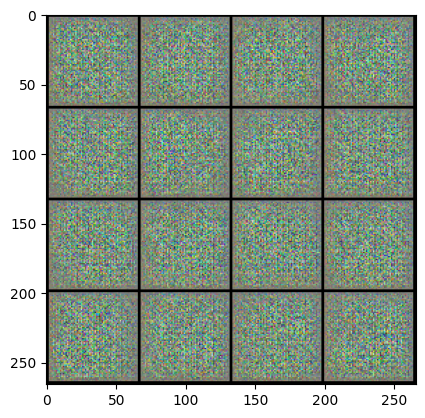

In [19]:
noise = torch.randn(16, latent_dim, device=device)
fake_image = generator(noise)
fake_output = discriminator(fake_image)
print(fake_image.shape, fake_output.shape
      )
show_image(fake_image, rescale=(1, 2))

## Training helper functions

In [20]:
def show_step_function(epoch, step, show_step, generator, disc_loss_list, gen_loss_list):
  print(f'Epoch: {epoch}, Step: {step}, Discriminator loss last {show_step}: {np.mean(disc_loss_list[-show_step:])}, \
  Generator loss last {show_step}: {np.mean(gen_loss_list[-show_step:])}')
  noise = torch.randn(16, latent_dim, device=device)
  fake_image = generator(noise)
  show_image(fake_image, rescale=(1, 2))
  plt.plot(
    range(len(gen_loss_list)),
    torch.Tensor(gen_loss_list),
    label="Generator Loss"
  )

  plt.plot(
    range(len(disc_loss_list)),
    torch.Tensor(disc_loss_list),
    label="Critic Loss"
  )
  max_max = np.max([np.max(gen_loss_list), np.max(disc_loss_list)])
  min_min = np.min([np.min(gen_loss_list), np.min(disc_loss_list)])
  plt.ylim((min_min - np.abs(min_min) * 0.05),
           (max_max + np.abs(max_max)*0.05))
  plt.legend()
  plt.show()

def training_step_discriminator(true_image, generator, discriminator, loss_fn):
  noise = torch.randn(true_image.shape[0], latent_dim, device=device)
  fake_image = generator(noise)
  fake_output = discriminator(fake_image.detach())
  true_output = discriminator(true_image)
  ones = torch.ones_like(true_output)
  zeros = torch.zeros_like(fake_output)
  arguments ={'fake_image': fake_image,
              'fake_output': fake_output,
              'true_image': true_image,
              'true_output': true_output,
              'discriminator': discriminator,
              'if_disc': True,
              'ones': ones,
              'zeros': zeros}
  loss = loss_fn(**arguments)
  return loss

def training_step_generator(batch_size, generator, discriminator, loss_fn):
  noise = torch.randn(batch_size, latent_dim, device=device)
  fake_image = generator(noise)
  fake_output = discriminator(fake_image)
  ones = torch.ones_like(fake_output)
  arguments ={'fake_image': fake_image,
              'fake_output': fake_output,
              'discriminator': discriminator,
              'if_disc': False,
              'ones': ones}
  loss = loss_fn(**arguments)
  return loss

def get_gp(real, fake, crit, alpha, gamma=10):
  mix_images = real * alpha + fake * (1-alpha) # 128 x 3 x 128 x 128
  mix_scores = crit(mix_images) # 128 x 1

  gradient = torch.autograd.grad(
      inputs = mix_images,
      outputs = mix_scores,
      grad_outputs=torch.ones_like(mix_scores),
      retain_graph=True,
      create_graph=True,
  )[0] # 128 x 3 x 128 x 128

  gradient = gradient.reshape(len(gradient), -1)   # 128 x 49152
  gradient_norm = gradient.norm(2, dim=1)
  gp = gamma * ((gradient_norm-1)**2).mean()

  return gp

def WGANLoss(fake_image, fake_output, true_image=None, true_output=None, discriminator=None, if_disc=True, **kwargs):
  if if_disc:
    alpha=torch.rand(len(true_image),1,1,1,device=device, requires_grad=True) # 128 x 1 x 1 x 1
    gp = get_gp(true_image, fake_image.detach(), discriminator, alpha)
    return fake_output.mean() - true_output.mean() + gp
  else:
    return -fake_output.mean()

## Training preparation

In [21]:
learning_rate = 1e-4
gen_optim = optim.AdamW(generator.parameters(), lr=learning_rate, betas=(0.5,0.9))
disc_optim = optim.AdamW(discriminator.parameters(), lr=learning_rate, betas=(0.5,0.9))
loss_fn = WGANLoss # nn.BCEWithLogitsLoss()

## Training

In [22]:
step = 0
show_step = 35
epochs = 100
disc_loss_list = []
gen_loss_list = []
epoch = 0
n_disc = 5
n_gen = 1
#show_step_function(epoch, step, show_step, generator, disc_loss_list, gen_loss_list)
for epoch in range(epochs):
  for true_image, _ in tqdm(dataloader):
    true_image = true_image.to(device)
    true_image = true_image * 2 - 1
    disc_loss_mean = 0
    for _ in range(n_disc):
      disc_optim.zero_grad()
      disc_loss = training_step_discriminator(true_image, generator, discriminator, loss_fn)
      disc_loss.backward()
      disc_optim.step()
      disc_loss_mean += disc_loss.item()/n_disc
    disc_loss_list.append(disc_loss_mean)

    gen_loss_mean = 0
    for _ in range(n_gen):
      gen_optim.zero_grad()
      gen_loss = training_step_generator(len(true_image), generator, discriminator, loss_fn)
      gen_loss.backward()
      gen_optim.step()
      gen_loss_mean += gen_loss.item()/n_gen
    gen_loss_list.append(gen_loss_mean)

    step += 1
    if step % show_step == 0:
      show_step_function(epoch, step, show_step, generator, disc_loss_list, gen_loss_list)


  0%|          | 0/58 [00:00<?, ?it/s]

KeyboardInterrupt: 